In [ ]:
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import gym

In [ ]:
print(tf.__version__)

2.8.0


## DQN (Deep Q Network)

In this lab, we will apply deep learning as function approximations in reinforcement learning. 

Reference: DQN https://arxiv.org/abs/1312.5602

In tabular Q-learning, we maintain a table of state-action pairs $(s,a)$ and save one action value for each entry $Q(s,a),\forall (s,a)$. At each time step $t$, we are in state $s_t$, then we choose action based on $\epsilon-$greedy strategy. With prob $\epsilon$, choose action uniformly random; with prob $1-\epsilon$, choose action based on $$a_t = \arg\max_a Q(s_t,a)$$ 

We then get the instant reward $r_t$, update the Q-table using the following rule

$$Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t) + \alpha (r_t + \max_a \gamma Q(s_{t+1},a))$$

where $\alpha \in (0,1)$ is learning rate. The algorithm is shown to converge in tabular cases. However, in cases where we cannot keep a table for state and action, we need function approximation. Consider using neural network with parameter $\theta$, the network takes as input state $s$ and action $a$. (*there are alternative parameterizations here*). Let $Q_\theta(s,a)$ be the output of the network, to estimate the optimal action value function in state $s$ and take action $a$ (and follow optimal policy thereafter). 

$$Q_\theta(s,a) \approx Q^\ast(s,a)$$

### Bellman optimality equation

We will use Bellman optimality equation to find $\theta$ such that the above approximation holds better. Recall that for optimal Q function $Q^\ast(s,a)$ the following holds for all $(s,a)$

$$Q^\ast(s_t,a_t) = \max_a \mathbb{E}\big[r_t + \gamma Q^\ast(s_{t+1},a)\big]$$

Hence a natural objective to consider is 

$$\min_\theta\  (Q_\theta(s_t,a_t) - \max_a \mathbb{E}\big[r_t + \gamma Q_\theta(s_{t+1},a)\big])^2$$

Let us first build a neural network $Q_\theta(s,a)$ as required above.

In [ ]:
# define neural net Q_\theta(s,a) as a class

class Qfunction(keras.Model):
    
    def __init__(self, obssize, actsize, hidden_dims):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        hidden_dims: list containing output dimension of hidden layers 
        """
        super(Qfunction, self).__init__()

        # Layer weight initializer
        initializer = keras.initializers.RandomUniform(minval=-1., maxval=1.)

        # Input Layer
        self.input_layer = keras.layers.InputLayer(input_shape=(obssize,))
        
        # Hidden Layer
        self.hidden_layers = []
        for hidden_dim in hidden_dims:
            # TODO: define each hidden layers
            layer = keras.layers.Dense(hidden_dim, activation='relu',
                                      kernel_initializer=initializer)
            self.hidden_layers.append(layer) 
        
        # Output Layer : 
        # TODO: Define the output layer.
        self.output_layer = keras.layers.Dense(actsize) 
    
    @tf.function
    def call(self, states):
        ########################################################################
        # TODO: You SHOULD implement the model's forward pass
        return None
        ########################################################################


In [ ]:
# Wrapper class for training Qfunction and updating weights (target network) 

class DQN(object):
    
    def __init__(self, obssize, actsize, hidden_dims, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        optimizer: 
        """
        self.qfunction = Qfunction(obssize, actsize, hidden_dims)
        self.optimizer = optimizer
        self.obssize = obssize
        self.actsize = actsize

    def _predict_q(self, states, actions):
        """
        states represent s_t
        actions represent a_t
        """
        ########################################################################
        # TODO: Define the logic for calculate  Q_\theta(s,a
        return None
        ########################################################################
        

    def _loss(self, Qpreds, targets):
        """
        Qpreds represent Q_\theta(s,a)
        targets represent the terms E[r+gamma Q] in Bellman equations

        This function is OBJECTIVE function
        """
        return tf.math.reduce_mean(tf.square(Qpreds - targets))

    
    def compute_Qvalues(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        inputs = np.atleast_2d(states.astype('float32'))
        return self.qfunction(inputs)


    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        with tf.GradientTape() as tape:
            Qpreds = self._predict_q(states, actions)
            loss = self._loss(Qpreds, targets)
        variables = self.qfunction.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss

    def update_weights(self, from_network):
        """
        We need a subroutine to update target network 
        i.e. to copy from principal network to target network. 
        This function is for copying  𝜃←𝜃target 
        """
        
        from_var = from_network.qfunction.trainable_variables
        to_var = self.qfunction.trainable_variables
        
        for v1, v2 in zip(from_var, to_var):
            v2.assign(v1)

Now that we have $Q_\theta(s,a)$ we can execute policies in the environment as follows ($\epsilon-$greedy).

In [ ]:
# # just pseudocode
# # Please comment out this cell when implementing the code
# raise ValueError("cannot attemp to run pseudocode")

# env = gym.make('CartPole-v0')
# epsilon = .1

# obs = env.reset()
# done = False
# rewardsum = 0

# while not done:
#     if np.random.rand() < epsilon:
#         action = env.action_space.sample()
#     else:
#         Q = DQN.compute_Qvalues(obs)
#         action = np.argmax(Q)  # need some tweeking of code here
    
#     obs, reward, done, info = env.step(action)
#     rewardsum += reward
    
# print("reward under current policy %f ".format(rewardsum)) 

We can hence collect a bunch of samples $(s_t,a_t,r_t,s_{t+1})$, and compute the targets using the current network. Let the target be $d_i$ as the $i$th target

$$d_i = \max_a r_t + \gamma Q_\theta(s_{t+1},a)$$

And then feed this value into the computational graph and minimize the Bellman error loss. This procedure has been shown to be fairly unstable. The reference paper has offered two techniques to stabilize the training process: target network and replay buffer.

**Replay Buffer**
Maintain a buffer $R$ to store trainsition tuples $(s_t,a_t,r_t,s_{t+1})$, when we minimize the Bellman error. When optimizing the Bellman error loss, we sample batches from the replay buffer and compute gradients for update on these batches. In particular, in each update, we sample $N$ tuples from buffer $(s_t,a_t,r_t,s_{t+1}) \sim R$ and then compute
loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - \max_a (r_i + \gamma Q_\theta(s_i^\prime,a))^2$$

and update parameters using backprop.

**Target Network**
Maintain a target network in addition to the original pricipal network. The target network is just a copy of the original network but the parameters are not updated by gradients. The target network $\theta_{\text{target}}$ is copied from the principal network every $\tau$ time steps. Target network is used to compute the targets for update

$$d_i = \max_a r_t + \gamma Q_{\theta^{-}}(s_{i}^\prime,a)$$

the targets are used in the loss function to update the principal network parameters. This slowly updated target network ensures that the targets come from a relatively stationary distribution and hence stabilize learning.

Hence several critical parts of the complete pseudocode for DQN is as follows:

**Initialization**: principal network $Q_\theta(s,a)$, target network $Q_{\theta^{-}}(s,a)$. Replay buffer $R = \{\}$ (empty). 

**At each time step $t$**: execute action using $\epsilon-$greedy based on the principal network $Q_\theta(s,a)$. To update $\theta$: sample $N$ tuples $(s_i,a_i,r_i,s_i^\prime) \sim R$, compute empirical loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - \max_a (r_i + \gamma Q_{\theta^{-}}(s_i^\prime,a))^2$$

and update parameter $\theta$ using backprop (just take one gradient step).

**Update target network**: Every $\tau$ time steps, update target network by copying $\theta_{\text{target}} \leftarrow \theta$.

In [ ]:
# Implement replay buffer
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        if(self.number > self.maxlength):
            self.pop()
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        inds = np.random.choice(len(self.buffer), batchsize, replace=False)
        return [self.buffer[idx] for idx in inds]
        

Now that we have all the ingredients for DQN, we can write the main procedure to train DQN on a given environment. The implementation is straightforward if you follow the pseudocode. Refer to the pseudocode pdf for details.

In [ ]:
################################################################################
# TODO: Set the required parameters. All parameters can be tuned by yourself.
lr = 5e-4  # learning rate for gradient update 
batchsize = 64  # batchsize for buffer sampling
maxlength = 10000  # max number of tuples held by buffer
envname = "CartPole-v0"  # environment name
tau = 100  # time steps for target update
episodes = 3000  # number of episodes to run
initialize = 500  # initial time steps before start updating
epsilon = .05  # constant for exploration
gamma = .99  # discount
hidden_dims=[10, 5] # hidden dimensions
################################################################################

# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

# optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)

# initialize networks
Qprincipal = DQN(obssize, actsize, hidden_dims, optimizer)
Qtarget = DQN(obssize, actsize, hidden_dims, optimizer)

# initialization of buffer
buffer = ReplayBuffer(maxlength)

################################################################################
# TODO: Complete the main iteration
# CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.

rrecord = []
totalstep = 0
for ite in range(episodes):

    obs = env.reset()
    done = False
    rsum = 0

    while not done:
        pass

################################################################################

    ## DO NOT CHANGE THIS PART!
    rrecord.append(rsum)
    if ite % 10 == 0:
        print('iteration {} ave reward {}'.format(ite, np.mean(rrecord[-10:])))
    
    ave100 = np.mean(rrecord[-100:])   
    if  ave100 > 195.0:
        print("Solved after %d episodes."%ite)
        break

iteration 0 ave reward 42.0
iteration 10 ave reward 15.7
iteration 20 ave reward 27.9
iteration 30 ave reward 10.0
iteration 40 ave reward 9.2
iteration 50 ave reward 9.6
iteration 60 ave reward 9.7
iteration 70 ave reward 9.7
iteration 80 ave reward 8.8
iteration 90 ave reward 10.0
iteration 100 ave reward 9.8
iteration 110 ave reward 9.5
iteration 120 ave reward 9.7
iteration 130 ave reward 9.9
iteration 140 ave reward 9.4
iteration 150 ave reward 10.2
iteration 160 ave reward 9.9
iteration 170 ave reward 8.9
iteration 180 ave reward 9.0
iteration 190 ave reward 9.5
iteration 200 ave reward 9.6
iteration 210 ave reward 9.7
iteration 220 ave reward 9.7
iteration 230 ave reward 9.8
iteration 240 ave reward 12.3
iteration 250 ave reward 21.6
iteration 260 ave reward 11.5
iteration 270 ave reward 10.3
iteration 280 ave reward 17.9
iteration 290 ave reward 95.7
iteration 300 ave reward 91.1
iteration 310 ave reward 80.1
iteration 320 ave reward 168.2
iteration 330 ave reward 128.2
iterati

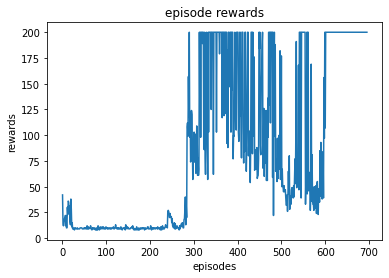

In [ ]:
# plot [episode, reward] history
x = [i+1 for i in range(len(rrecord))]
plt.plot(x, rrecord)
plt.title('episode rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

Once you run the code, save the notebook file of name "Lab 3_your name.ipynb" and submit on eTL.

# Do NOT submit as zip files.